In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
from io import BytesIO
import os
from importlib import reload
import src.models.curation_treatment as ct 
from sentence_transformers import util
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
reload(ct)


/opt/homebrew/anaconda3/envs/‘gsoc_harmon_2024’/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.models.curation_treatment' from '/Users/abhilashdhal/Desktop/cbioportal_gsoc/OmicsMLRepoHarmonizer/src/models/curation_treatment.py'>

## 0. Function for barplot accuracy

In [8]:

def create_accuracy_bar_plot(data, title):
    # Calculate accuracy for Top 1, Top 3, and Top 5 matches
    data['top1_accuracy'] = data.apply(lambda row: row['curated_ontology'] == row['top1_match'], axis=1)
    data['top3_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match']].values, axis=1)
    data['top5_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match', 'top4_match', 'top5_match']].values, axis=1)

    # Calculate percentage accuracies
    top1_accuracy = data['top1_accuracy'].mean() * 100
    top3_accuracy = data['top3_accuracy'].mean() * 100
    top5_accuracy = data['top5_accuracy'].mean() * 100

    # Prepare data for plotting
    accuracy_data = {
        'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
        'Accuracy': [top1_accuracy, top3_accuracy, top5_accuracy]
    }

    accuracy_df = pd.DataFrame(accuracy_data)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(accuracy_df['Accuracy Level'], accuracy_df['Accuracy'], color=['blue', 'orange', 'green'])
    plt.xlabel('Match Level')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.ylim(0, 100)
    plt.show()
    return accuracy_data

## 1. Test different sentence transformers' performance

1. Test initialization 
2. Test embedding generation 
3. Test semantics similarity mapping
4. Combined function for all three functions in a get_match_results

In [3]:
source_dir = "./"
map_url = os.path.join(source_dir, "data/cBioPortal_treatment_name_map.csv")
df = pd.read_csv(map_url)
df = df[["original_value", "curated_ontology", "curated_ontology_term_id"]]
orig_cura_map = dict(zip(df["original_value"], df["curated_ontology"]))
ct_instance_bio_bert = ct.CuraTreatment(cura_map=orig_cura_map, method='bio-bert', from_tokenizer=False)
ct_instance_pubmed = ct.CuraTreatment(cura_map=orig_cura_map, method='pubmed-bert', from_tokenizer=False)
ct_instance_cb = ct.CuraTreatment(cura_map=orig_cura_map, method='clinical-bert', from_tokenizer=True)
ct_instance_bb = ct.CuraTreatment(cura_map=orig_cura_map, method='big-bird', from_tokenizer=True)

20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220820 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module


In [4]:
ct_instance_base_bert = ct.CuraTreatment(cura_map=orig_cura_map, method='bert-base', from_tokenizer=False)

20/05//2024 09:30:1716220826 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220826 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220826 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220826 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module
20/05//2024 09:30:1716220826 PM - DEBUG - CuraTreatment: Initialized CuraTreatment module


In [5]:
# results_df_base_bert = ct_instance_bert.get_match_results()
results_df_pubmed_bert = ct_instance_pubmed.get_match_results()
results_df_cb = ct_instance_cb.get_match_results()
results_df_bio_bert = ct_instance_bio_bert.get_match_results()
results_df_base_bert = ct_instance_base_bert.get_match_results()

20/05//2024 09:30:1716220847 PM - INFO - CuraTreatment.get_match_results: Creating embeddings for query_list and corpus
20/05//2024 09:30:1716220847 PM - INFO - CuraTreatment.get_match_results: Creating embeddings for query_list and corpus
20/05//2024 09:30:1716220847 PM - INFO - CuraTreatment.get_match_results: Creating embeddings for query_list and corpus
20/05//2024 09:30:1716220847 PM - INFO - CuraTreatment.get_match_results: Creating embeddings for query_list and corpus
20/05//2024 09:30:1716220847 PM - INFO - CuraTreatment.get_match_results: Creating embeddings for query_list and corpus
20/05//2024 09:30:1716220859 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:30:1716220859 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:30:1716220859 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:30:1716220859 PM - INFO - CuraTreatment.get_match_re

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220877 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220877 PM - INFO - CuraTrea

No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with MEAN pooling.
No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with MEAN pooling.


20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Calculating cosine similarity matrix
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220887 PM - INFO - CuraTreatment.get_match_results: Generating results table
20/05//2024 09:31:1716220887 PM - INFO - CuraTrea

## 2. Generate barplots of accuracy of different transformers

In [6]:
data_pubmed = results_df_pubmed_bert.copy()
data_cb = results_df_cb.copy()
data_bio_bert = results_df_bio_bert.copy()
data_base_bert = results_df_base_bert.copy()

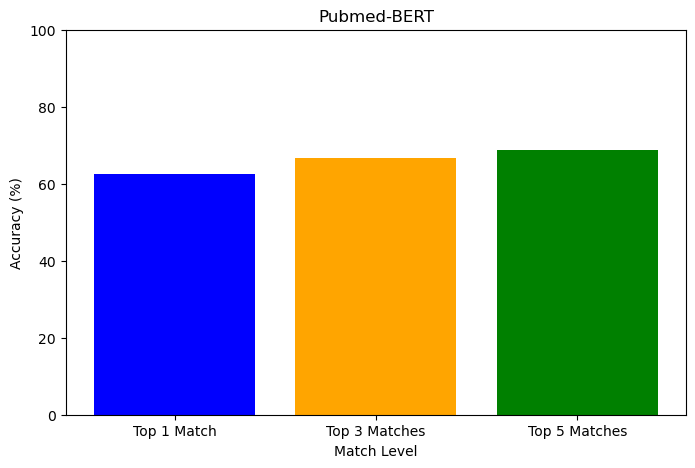

{'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
 'Accuracy': [62.527233115468405, 66.66666666666666, 68.73638344226579]}

In [9]:
create_accuracy_bar_plot(data_pubmed, 'Pubmed-BERT')

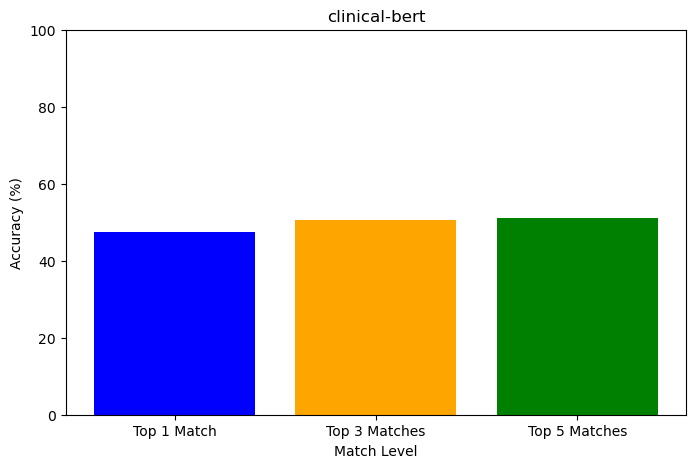

{'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
 'Accuracy': [47.49455337690632, 50.65359477124183, 51.19825708061002]}

In [10]:
create_accuracy_bar_plot(data_cb, ct_instance_cb.method)

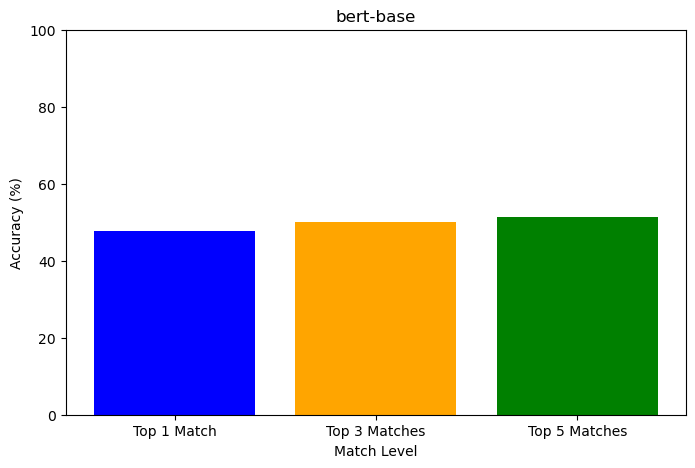

{'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
 'Accuracy': [47.60348583877996, 50.0, 51.4161220043573]}

In [13]:
create_accuracy_bar_plot(data_base_bert, ct_instance_base_bert.method)

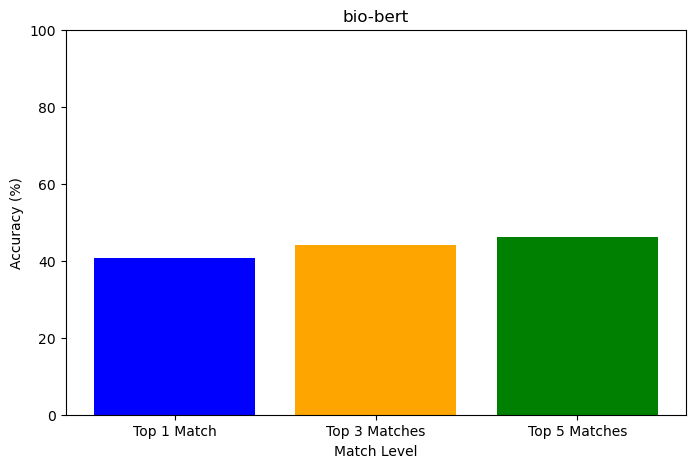

{'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
 'Accuracy': [40.631808278867105, 44.11764705882353, 46.07843137254902]}

In [11]:
create_accuracy_bar_plot(data_bio_bert, ct_instance_bio_bert.method)